# Espectral Semicilindros Geant4

(10, 256, 256)
Archivo RAW stack: C:/Users/Esteban Gomez/OneDrive - Universidad de los Andes/Archivos universidad/Tesis Esteban/Simulaciones Python con sangre y HA/RAW sangre/RAW_Sangre15keV.txt
Archivo FF stack: C:/Users/Esteban Gomez/OneDrive - Universidad de los Andes/Archivos universidad/Tesis Esteban/Simulaciones Python con sangre y HA/FF/FF15keV.txt


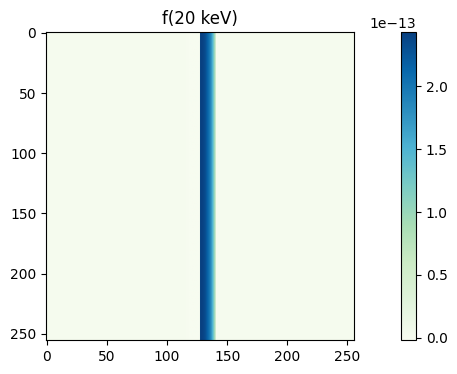

In [12]:
import numpy as np
from pathlib import Path
from typing import List, Tuple
import matplotlib.pyplot as plt

#Constantes
h = 1.054571817e-34 #joules*s
c = 2.99792458e8 #m/s
Q = 1.602e-19 #Para pasar de keV a joules


#Para convertir keV a joules
def keV_joules(Energias:np.ndarray)->np.ndarray:
    return Energias * Q * 1e3

#Cremos el Stack de las imagenes
def load_txt_stack(paths: List[str]) -> np.ndarray:
    mats = []
    for p in paths:
        arr = np.loadtxt(p)
        mats.append(arr)
    return np.stack(mats, axis=0)

#Calculamos f(E)=k*ln(I0/I)
def f_E(ff_paths: List[str], raw_paths: List[str], energies_keV: List[float], epsilon: float = 1e-12) -> Tuple[np.ndarray, np.ndarray]:
    
    # Cargar imágenes
    FF   = load_txt_stack(ff_paths)
    #print(FF)# (nE, H, W)
    RAW  = load_txt_stack(raw_paths)  # (nE, H, W)
    
    #k(E) = ħ c / (2 E)
    E_J   = keV_joules(np.asarray(energies_keV, dtype=float))    # (nE,)
    k = (h * c) / (2.0 * E_J)                                   # (nE,)

    # ln(FF/RAW) por energía
    ln = np.log(FF / RAW)                             # (nE, H, W)

    # Multiplicar por k(E) respetando broadcasting: (nE,1,1)
    f_e = (k[:, None, None]) * ln                       # (nE, H, W)
    return f_e, k


#Valores 

energias = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60]  # Energías en keV
raw  = [f"C:/Users/Esteban Gomez/OneDrive - Universidad de los Andes/Archivos universidad/Tesis Esteban/Simulaciones Python con sangre y HA/RAW sangre/RAW_Sangre{e:.0f}keV.txt" for e in energias]#Rutas raw
ff = [f"C:/Users/Esteban Gomez/OneDrive - Universidad de los Andes/Archivos universidad/Tesis Esteban/Simulaciones Python con sangre y HA/FF/FF{e:.0f}keV.txt" for e in energias]#Rutas de ff
FE, K = f_E(ff, raw, energias)


#------Comprobación visual f(E)------
print(FE.shape)
f_E1 = FE[9, :, :]  
plt.figure(figsize=(12,4))
plt.imshow(f_E1, cmap='GnBu')
plt.title("f(20 keV)")
plt.axis('on')
plt.colorbar()
print("Archivo RAW stack:", raw[0])
print("Archivo FF stack:", ff[0])
#------------------------------------

In [13]:
# Empezamos definiendo los betas para cada material a cada energía
Beta_PMMA = np.array([8.4447E-10, 3.3454E-10, 1.8115E-10, 1.1789E-10, 8.6288E-11, 6.8306E-11, 5.6772E-11, 4.8513E-11, 4.2404E-11, 3.7577E-11])
Beta_HA = np.array([3.0579E-08, 1.0015E-08, 4.2474E-09, 2.141E-09, 1.2194E-09, 7.6015E-10, 5.088E-10, 3.623E-10, 2.7129E-10, 2.1123E-10])
Beta_sangre = np.array([1.2098E-09, 4.4151E-10, 2.2131E-10, 1.3484E-10, 9.3426E-11, 7.0748E-11, 5.6989E-11, 4.7676E-11, 4.1178E-11, 3.6148E-11])
#Beta_Al = np.array([1.33E-08, 4.3768E-09 ,1.90248E-09 ,1.01135E-09 ,6.17363E-10 ,4.16727E-10 ,3.03435E-10 ,2.33582E-10 ,1.88145E-10 ,1.55956E-10])
#Como arriba quitamos la contribución del PMMA, los betas del HA y de la sangre quedan relativos al beta del PMMA
Beta_HA_rel = Beta_HA - Beta_PMMA 
Beta_Sangre_rel = Beta_sangre - Beta_PMMA

Matriz_betas = np.column_stack((Beta_HA_rel, Beta_Sangre_rel))  # Matriz de betas relativa (9x2)
print("Matriz de betas relativa (10x2):")
print(Matriz_betas)

#--------------------------------------------------------------------------------------------------------------------------

#vamos a armar la matriz f(E), en esta matriz cada fila es un pixel y cada columna una energía
#f_E es mi stack de la forma 9,256,256
num_capas = FE.shape[0]  # Número de energías (capas)
total_pixeles = FE.shape[1] * FE.shape[2]  # Total de píxeles por capa
print(num_capas)
print(total_pixeles)
#Ahora voy a aplanar cada capa de 256x256 a un vector de 65536x1 y luego apilar esos vectores para formar una matriz de 9x65536|
fE_final = FE.reshape(num_capas, total_pixeles)  # Matriz final de f(E) de forma (9, 65536)
print(fE_final)

print(f"Por ejemplo el primer valor (n12) de cada matriz es:{FE[:,0,1]}")
print(f"Y la segunda columna es {fE_final[:,1].reshape(-1,1)}")

#--------------------------------------------------------------------------------------------------------------------------


Matriz de betas relativa (10x2):
[[ 2.973453e-08  3.653300e-10]
 [ 9.680460e-09  1.069700e-10]
 [ 4.066250e-09  4.016000e-11]
 [ 2.023110e-09  1.695000e-11]
 [ 1.133112e-09  7.138000e-12]
 [ 6.918440e-10  2.442000e-12]
 [ 4.520280e-10  2.170000e-13]
 [ 3.137870e-10 -8.370000e-13]
 [ 2.288860e-10 -1.226000e-12]
 [ 1.736530e-10 -1.429000e-12]]
10
65536
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Por ejemplo el primer valor (n12) de cada matriz es:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Y la segunda columna es [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [14]:
#Vamos a resolver el sistema f = AZ por minimos cuadrados
# Z = (A^T A)^(-1) A^T f
#----------------------------------------------------------------
#Paso 1 : Calcular A^T A
A_T = Matriz_betas.T  # Transpuesta de A (2x10)
#print(A_T)
A_T_A = A_T @ Matriz_betas  # Producto A^T A (2x2)
#print(A_T_A)
#----------------------------------------------------------------
#Regresión de ridge
#I = np.identity(A_T_A.shape[0])
#A_T_A_Ridge = A_T_A + 0 * I
#Paso 2: Calcular la inversa de A^T A
A_T_A_inv = np.linalg.inv(A_T_A)  # Inversa de A^T A (2x2)
#print(A_T_A_inv)
#----------------------------------------------------------------
#Paso 3: Calcular A_T_A_inv @ A^T
A_pseudo_inv = A_T_A_inv @ A_T  # Pseudoinversa de A (2x10)
#print(A_pseudo_inv)
#----------------------------------------------------------------
#Paso 4: Calcular Z = A_pseudo_inv @ f para cada píxel
Z = A_pseudo_inv @ fE_final  # Matriz Z de forma (2, 65536)
#print(Z)  # Cada fila corresponde a un material, cada columna a un píxel
print("\n--- Resultado Final ---")
print(f"Dimensión de Z (Grosores), cada fila corresponde a un material y cada columna a un pixel: {Z.shape}")
#----------------------------------------------------------------
#Paso 5: Vamos a reshappear Z para tener las imagenes de cada material
# La matriz Z tiene: Fila 0 = Grosor HA, Fila 1 = Grosor Sangre
Z_HA_plano = Z[0, :] 
Z_Al_plano = Z[1, :]
# np.reshape(256, 256) transforma el vector 1x65536 de vuelta a la imagen.
Z_HA_imagen = Z_HA_plano.reshape(256, 256)
Z_Al_imagen = Z_Al_plano.reshape(256, 256)
print(f"Dimensión de la imagen de Grosor HA/Placa: {Z_HA_imagen.shape}")
print(Z_HA_imagen[128,128])


--- Resultado Final ---
Dimensión de Z (Grosores), cada fila corresponde a un material y cada columna a un pixel: (2, 65536)
Dimensión de la imagen de Grosor HA/Placa: (256, 256)
0.0014000000000000826


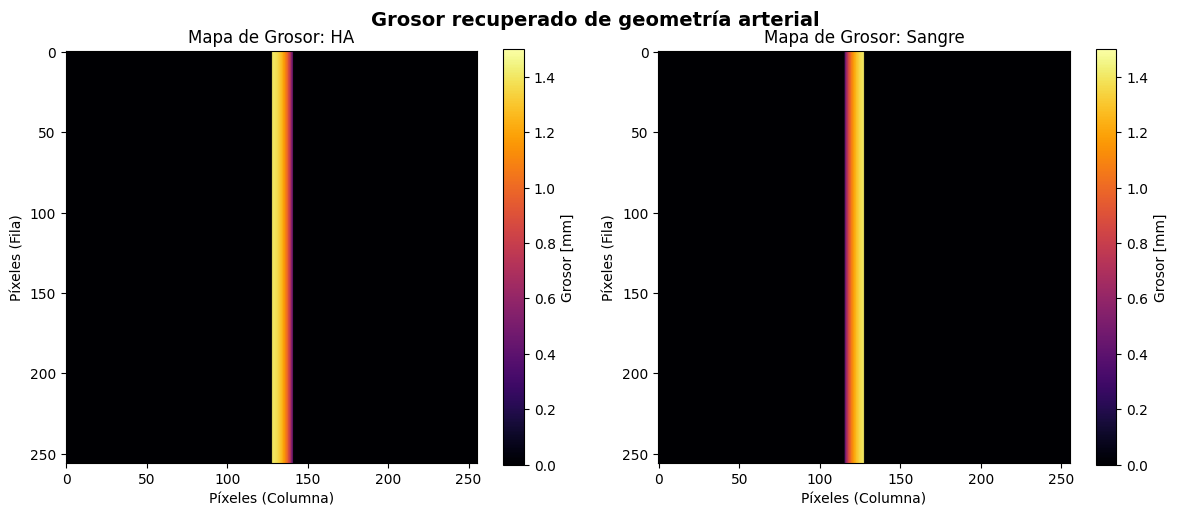

In [19]:
# 1. Crear una figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 
fig.suptitle('Grosor recuperado de geometría arterial', fontsize=14, fontweight='bold')
# ----------------------------------------------------------------------
# 2. GRAFICAR MAPA DE GROSOR HA/PLACA (Material 1)
# ----------------------------------------------------------------------
im1 = axes[0].imshow(
    Z_HA_imagen*1e3, 
    cmap='inferno',  # Mapa de color: bueno para datos científicos
    origin='upper',
    vmax=1.5# La convención usual para imágenes de datos es que (0,0) esté arriba
)
axes[0].set_title('Mapa de Grosor: HA')
axes[0].set_xlabel('Píxeles (Columna)')
axes[0].set_ylabel('Píxeles (Fila)')

# Barra de color para el grosor del Material 1
plt.colorbar(im1, ax=axes[0], label='Grosor [mm]')


# ----------------------------------------------------------------------
# 3. GRAFICAR MAPA DE GROSOR SANGRE (Material 2)
# ----------------------------------------------------------------------
im2 = axes[1].imshow(
    Z_Al_imagen*1e3, 
    cmap='inferno',  # Usamos un cmap diferente para distinguirlo visualmente
    origin='upper',
    vmax=1.5
)
axes[1].set_title('Mapa de Grosor: Sangre')
axes[1].set_xlabel('Píxeles (Columna)')
axes[1].set_ylabel('Píxeles (Fila)')

# Barra de color para el grosor del Material 2
plt.colorbar(im2, ax=axes[1], label='Grosor [mm]')

# 4. Mostrar el gráfico
plt.tight_layout() # Ajusta automáticamente los subplots para que no se superpongan
plt.show()


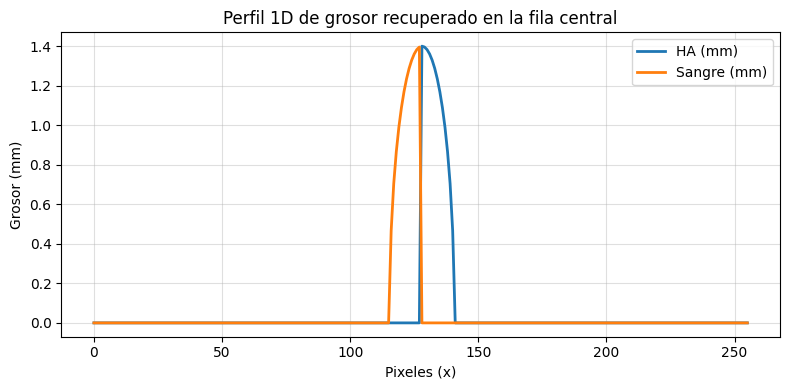

In [18]:
# Fila central de la imagen (puedes cambiarla)
fila_central = Z_HA_imagen.shape[0] // 2  

# Extraer la línea central (perfil) para cada material
perfil_HA = Z_HA_imagen[fila_central, :]
perfil_Al = Z_Al_imagen[fila_central, :]

# Crear eje en píxeles (x)
pixeles = np.arange(Z_HA_imagen.shape[1])

# --- Gráfica ---
plt.figure(figsize=(8, 4))
plt.plot(pixeles, perfil_HA * 1e3, label='HA (mm)', lw=2)   # convierte de m → mm
plt.plot(pixeles, perfil_Al * 1e3, label='Sangre (mm)', lw=2)
plt.xlabel('Pixeles (x)')
plt.ylabel('Grosor (mm)')
plt.title('Perfil 1D de grosor recuperado en la fila central')
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# Comparación entre Grosores teoricos y recuperados

máx |t_total - t_big| = 0.0


C:\Users\Esteban Gomez\AppData\Local\Temp\ipykernel_18332\1101113874.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reds_cmap = cm.get_cmap('Reds')
C:\Users\Esteban Gomez\AppData\Local\Temp\ipykernel_18332\1101113874.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  inferno_cmap = cm.get_cmap('inferno')


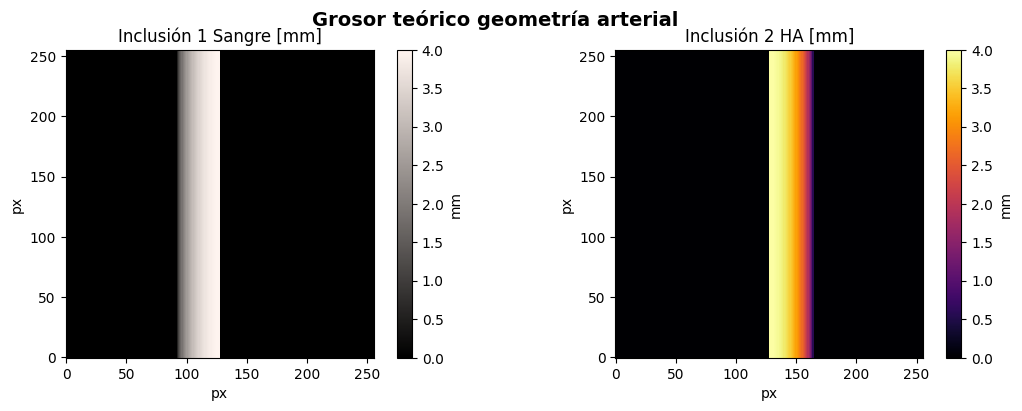

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# ---------------- Parámetros del detector ----------------
N = 256                 # 256x256 píxeles
pix_mm = 0.055          # 55 µm en mm
xc = yc = N // 2        # centro en píxeles

# ---------------- Geometría (mm) ----------------
R_big_mm   = 3.0        # radio cilindro grande (PMMA)
R_inner_mm = 2.0        # radio del cilindro interno que se parte en dos (Alúmina/HA)

# ---------------- Utilidades ----------------
x_px = np.arange(N)
x_mm = (x_px - xc) * pix_mm

def thickness_circle_1d(x_px, xc_px, R_mm, pix_mm):
    """Espesor 1D (mm) de un cilindro de radio R_mm centrado en xc_px."""
    dx_mm = (x_px - xc_px) * pix_mm
    t = np.zeros_like(dx_mm, dtype=float)
    mask = np.abs(dx_mm) <= R_mm
    t[mask] = 2.0 * np.sqrt(R_mm**2 - dx_mm[mask]**2)
    return t

# ---------------- Perfiles 1D ----------------
t_big   = thickness_circle_1d(x_px, xc, R_big_mm,   pix_mm)   # PMMA grande
t_inner = thickness_circle_1d(x_px, xc, R_inner_mm, pix_mm)   # círculo interno (2 mm)

# Partición en dos medios cilindros (infinito en Y)
left_mask  = x_px < xc   # mitad izquierda (incluye el centro)
right_mask = x_px >= xc   # mitad derecha (incluye el centro)

t_left  = np.where(left_mask,  t_inner, 0.0)   # Alúmina
t_right = np.where(right_mask, t_inner, 0.0)   # HA

# Matriz PMMA = grande - inclusiones (recortado a ≥0 por seguridad numérica)
t_matrix = np.clip(t_big - (t_left + t_right), 0.0, None)

# Chequeo de consistencia
t_total = t_matrix + t_left + t_right
print("máx |t_total - t_big| =", np.max(np.abs(t_total - t_big)))

# ---------------- Mapas 2D (apilado en Y) ----------------
t_big_img    = np.tile(t_big,    (N, 1))      # PMMA total
t_matrix_img = np.tile(t_matrix, (N, 1))      # PMMA matriz (sin inclusiones)
t_left_img   = np.tile(t_left,   (N, 1))      # Alúmina (medio cilindro izq.)
t_right_img  = np.tile(t_right,  (N, 1))      # HA (medio cilindro der.)
t_total_img  = np.tile(t_total,  (N, 1))      # Verificación


# ---------------- Visualización ----------------
vmax_big   = 2 * R_big_mm
vmax_inner = 2 * R_inner_mm


fig = plt.figure(figsize=(13, 4))
fig.suptitle('Grosor teórico geometría arterial', fontsize=14, fontweight='bold')
# Crear colormap rojo sobre fondo negro
reds_cmap = cm.get_cmap('Reds')
reds_black = mcolors.LinearSegmentedColormap.from_list(
    'Reds_black', [(0, 'black'), (1, reds_cmap(1))], N=256
)

# Crear colormap inferno con fondo negro (ya es oscuro, pero lo reforzamos)
inferno_cmap = cm.get_cmap('inferno')
inferno_black = mcolors.LinearSegmentedColormap.from_list(
    'Inferno_black', [(0, 'black'), (1, inferno_cmap(1))], N=256
)
# ------------------- Inclusión 1 -------------------
ax1 = plt.subplot(1, 2, 1)
im1 = ax1.imshow(t_left_img, origin='lower', cmap=reds_black,
                 interpolation='nearest', vmin=0, vmax=vmax_inner, aspect='equal')
ax1.set_title('Inclusión 1 Sangre [mm]')
ax1.set_xlabel('px'); ax1.set_ylabel('px')
plt.colorbar(im1, ax=ax1, label='mm')

# ------------------- Inclusión 2 -------------------
ax2 = plt.subplot(1, 2, 2)
im2 = ax2.imshow(t_right_img, origin='lower', cmap="inferno",
                 interpolation='nearest', vmin=0, vmax=vmax_inner, aspect='equal')
ax2.set_title('Inclusión 2 HA [mm]')
ax2.set_xlabel('px'); ax2.set_ylabel('px')
plt.colorbar(im2, ax=ax2, label='mm')

1.2679375477527859
1.246122736731823


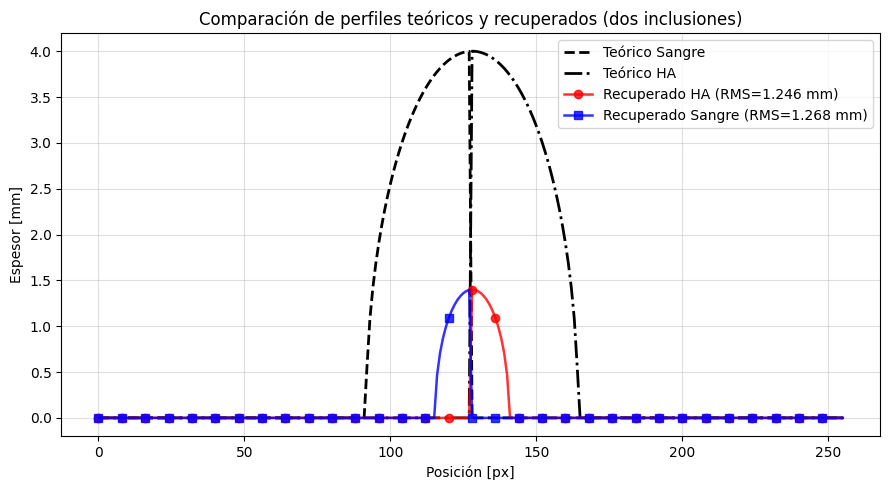

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# --------- Parámetros básicos ----------
y_centro = t_left_img.shape[0] // 2
pixeles = np.arange(t_left_img.shape[1])

# --------- Perfiles teóricos ----------
perfil_teo_izq = t_left_img[y_centro, :]
perfil_teo_der = t_right_img[y_centro, :]

# --------- Perfiles recuperados ----------
fila_central = Z_HA_imagen.shape[0] // 2
perfil_HA = Z_HA_imagen[fila_central, :] * 1e3
perfil_Al = Z_Al_imagen[fila_central, :] * 1e3

# --- Calcular errores RMS ---
rms_izq = np.sqrt(np.mean((perfil_teo_izq - perfil_HA)**2))
rms_der = np.sqrt(np.mean((perfil_teo_der - perfil_Al)**2))

print (rms_der)
print(rms_izq)

# --------- Gráfica comparativa ----------
plt.figure(figsize=(9,5))

# Perfiles teóricos
plt.plot(pixeles, perfil_teo_izq, 'k--', lw=2, label='Teórico Sangre', zorder=2)
plt.plot(pixeles, perfil_teo_der, 'k-.',  lw=2, label='Teórico HA',   zorder=2)

# Perfiles recuperados (con transparencia y marcadores)
plt.plot(pixeles, perfil_HA, 'r-', lw=1.8, alpha=0.8, marker='o', markevery=8,
         label=f'Recuperado HA (RMS={rms_izq:.3f} mm)', zorder=3)
plt.plot(pixeles, perfil_Al, 'b-', lw=1.8, alpha=0.8, marker='s', markevery=8,
         label=f'Recuperado Sangre (RMS={rms_der:.3f} mm)',   zorder=3)

plt.xlabel('Posición [px]')
plt.ylabel('Espesor [mm]')
plt.title('Comparación de perfiles teóricos y recuperados (dos inclusiones)')
plt.grid(True, alpha=0.4)
plt.legend(ncol=1)
plt.tight_layout()
plt.show()